In [1]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import emot
import re
import numpy as np
from collections import defaultdict
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
import csv
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home1/rgordon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# create dictionary of terms with valence, arousal, and dominance rankings

file_name = '/joy/joyData/WordRankings/NRC-VAD-Lexicon.txt'

terms = {}
va = []
ar = []
do = []
counter=0 

# read words file and store valence, arousal, and dominance in a dictionary
with open(file_name, 'r') as f:
    lines=f.readlines()
    
    for row in lines:
        row_=row.split("\t")
        try:
            terms[row_[0]] = counter
            va.append(float(row_[1]))
            ar.append(float(row_[2]))
            do.append(float(row_[3]))
            counter +=1
        except:
            print(row_)

In [3]:
# vectorization
df = pd.read_csv('/joy/joyData/allData')

count_vectorizer = CountVectorizer(vocabulary=terms, ngram_range=(1,2))
count_vectors = count_vectorizer.fit_transform(df['clean_tweet'].values.astype('U')).toarray()

tfidf_vectorizer = TfidfVectorizer(vocabulary=terms, ngram_range=(1,2))
tfidf_vectors = tfidf_vectorizer.fit_transform(df['clean_tweet'].values.astype('U')).toarray()


In [4]:
# functions to remove unnecessary data

def remove_zeros(vectors):
    
    #print the shape of the original matrix
    print("original matrix size", vectors.shape)

    #mark all-zero columns
    mask = (vectors == 0).all(0)

    # Find the indices of these columns (we might need those)
    column_indices = np.where(mask)[0]

    # Update vectors to only include the columns where non-zero values occur.
    vectors = vectors[:,~mask]

    #print the shape of the new vector matrix
    print("compact matrix size", vectors.shape)
    
    return vectors

def remove_sparse_rows(vectors, n_words):
    return vectors[np.count_nonzero(vectors==0, axis=1) < vectors.shape[1]-n_words]

In [5]:
# CLUSTERING FUNCTIONS

# selecting best value for k
def best_k(vectors):
    
    Sum_of_squared_distances = []
    k = range(4,15)
    for num_clusters in k :
        kmeans = KMeans(n_clusters=num_clusters, max_iter = 1000)
        kmeans.fit(vectors)
        Sum_of_squared_distances.append(kmeans.inertia_)
 
    plt.plot(k,Sum_of_squared_distances,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Sum of squared distances/Inertia') 
    plt.title('Best Number of Clusters')
    plt.show()
    
    
# clustering
def clust(vectors, k):
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    kmeans_vectors = model.fit_predict(vectors)


    #let's plot the PCA 
    pca = PCA(2)
    pca.fit(vectors)
    docs_pca = pca.transform(vectors)


    plt.figure(figsize = (8, 8))
    plt.grid()
    sns.scatterplot(x=docs_pca[:, 0], y=docs_pca[:, 1], hue=kmeans_vectors, palette=sns.color_palette("bright", k))
    plt.show()
    
    return model



# create word clouds
def word_clouds(base_vectors, clust_model, k):

    k_ = clust_model.predict(base_vectors)

    result={'cluster':k_,'data':df['clean_tweet']}
    result=pd.DataFrame(result)


    stopWords = stopwords.words('english')
    stopWords.extend(['joy', 'amp', 'happy', 'people', 'love', 'chicago', 'time', 'much', 'thank', 'bring', 'day'])

    for k in range(0,k):
       print("Cluster {}\n".format(k))
       s=result[result.cluster==k]
       text=s['data'].str.cat(sep=' ')
       text=' '.join([word for word in text.split() if word.lower() not in stopWords])
       wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
  
       plt.figure()
       plt.imshow(wordcloud, interpolation="bilinear")
       plt.axis("off")
       plt.show()

In [6]:
# TFIDF VECTORS CLUSTERING COMPARISON
a = remove_sparse_rows(tfidf_vectors, 1)

tfidf_vectors.shape, a.shape

((18226, 19971), (14377, 19971))

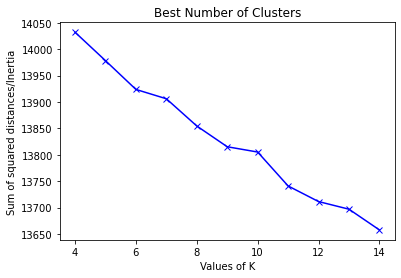

In [7]:
# selecting best value for k
best_k(a)

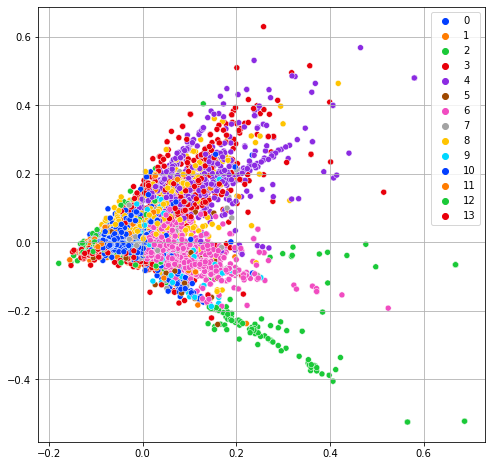

Cluster 0



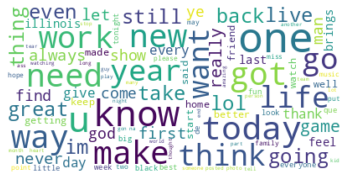

Cluster 1



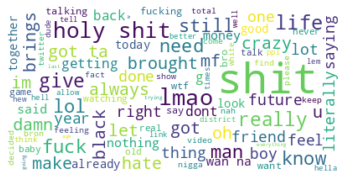

Cluster 2



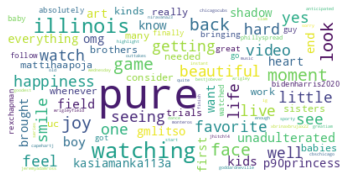

Cluster 3



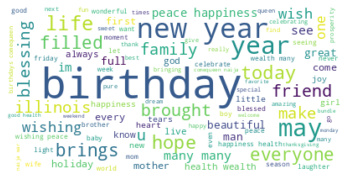

Cluster 4



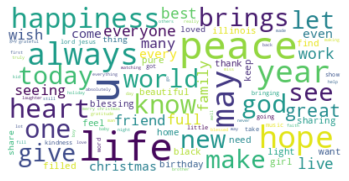

Cluster 5



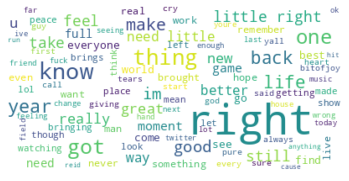

Cluster 6



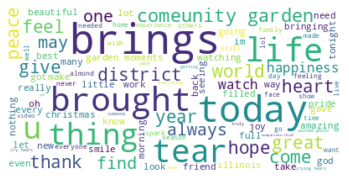

Cluster 7



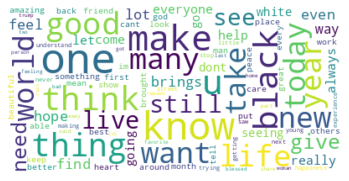

Cluster 8



Cluster 9



Cluster 10



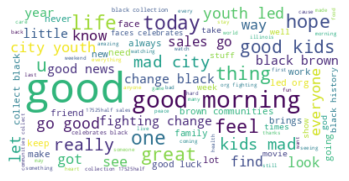

Cluster 11



Cluster 12



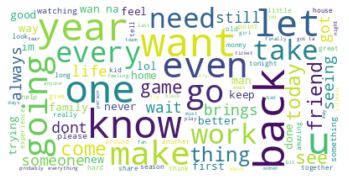

Cluster 13



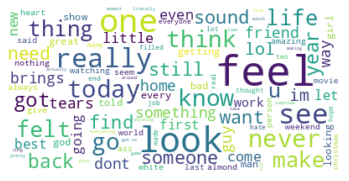

In [7]:
# clustering on tfidf vectors with sparse rows with only 1 word removed
a_model = clust(a, k=14)
word_clouds(tfidf_vectors, a_model, k=14)

In [13]:
b = remove_sparse_rows(tfidf_vectors, 2)

tfidf_vectors.shape, b.shape

((18226, 19971), (12304, 19971))

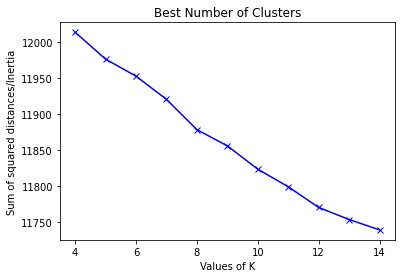

In [14]:
# selecting best value for k
best_k(b)

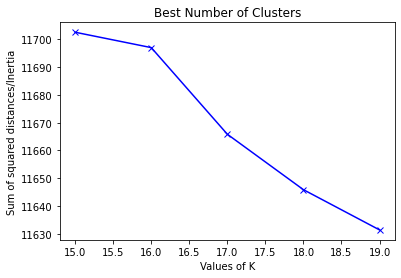

In [15]:
Sum_of_squared_distances = []
k = range(15,20)
for num_clusters in k :
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 1000)
    kmeans.fit(b)
    Sum_of_squared_distances.append(kmeans.inertia_)
 
plt.plot(k,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Best Number of Clusters')
plt.show()

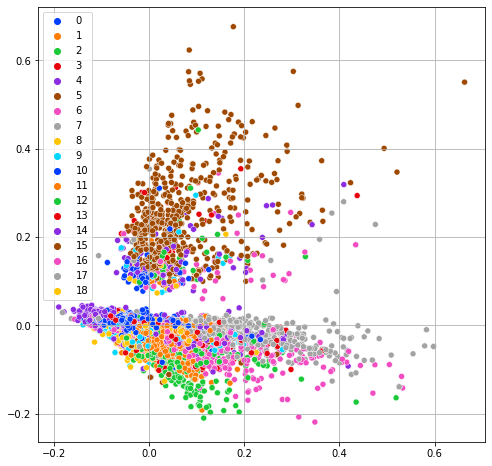

Cluster 0



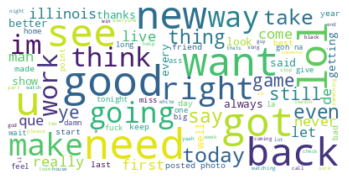

Cluster 1



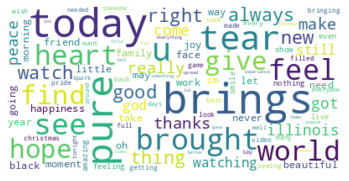

Cluster 2



Cluster 3



Cluster 4



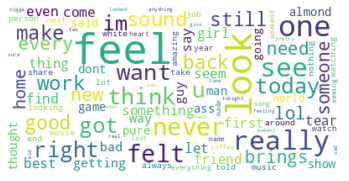

Cluster 5



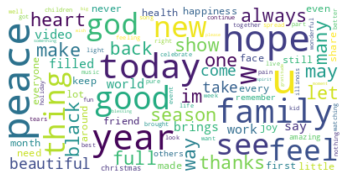

Cluster 6



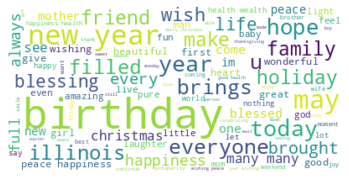

Cluster 7



Cluster 8



Cluster 9



Cluster 10



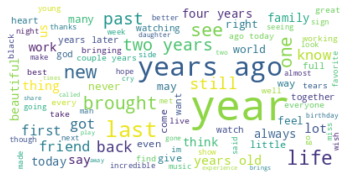

Cluster 11



Cluster 12



Cluster 13



Cluster 14



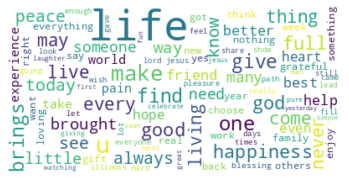

Cluster 15



Cluster 16



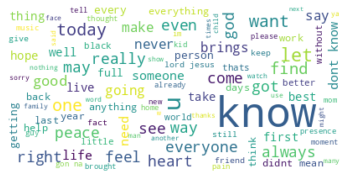

Cluster 17



Cluster 18



In [16]:
# clustering on tfidf vectors with sparse rows with only 2 words removed
b_model = clust(b, k=19)
word_clouds(tfidf_vectors, b_model, k=19)

In [17]:
c = remove_sparse_rows(tfidf_vectors, 3)

tfidf_vectors.shape, c.shape

((18226, 19971), (10491, 19971))

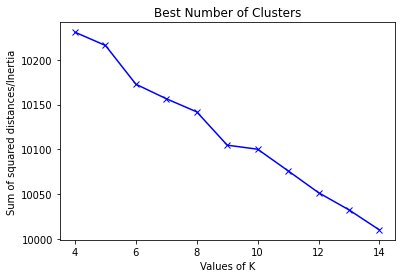

In [18]:
# selecting best value for k
best_k(c)

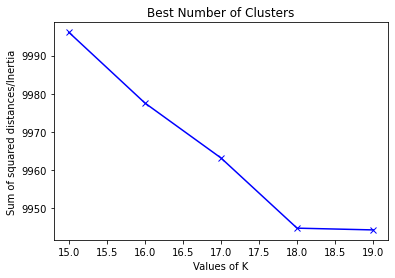

In [19]:
Sum_of_squared_distances = []
k = range(15,20)
for num_clusters in k :
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 1000)
    kmeans.fit(c)
    Sum_of_squared_distances.append(kmeans.inertia_)
 
plt.plot(k,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Best Number of Clusters')
plt.show()

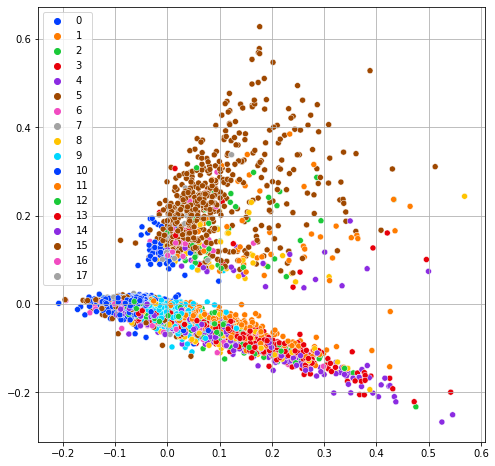

Cluster 0



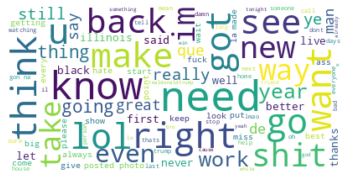

Cluster 1



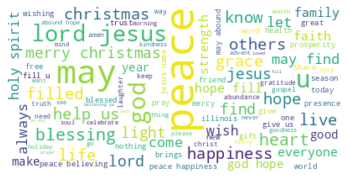

Cluster 2



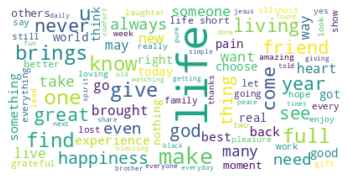

Cluster 3



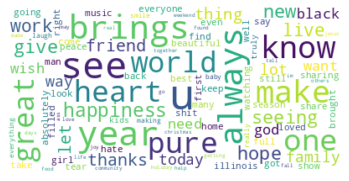

Cluster 4



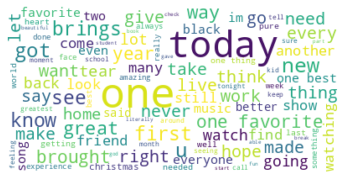

Cluster 5



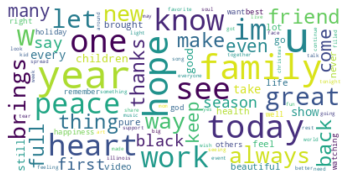

Cluster 6



Cluster 7



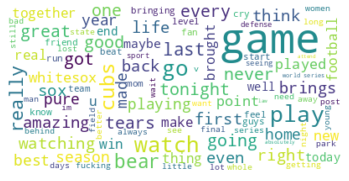

Cluster 8



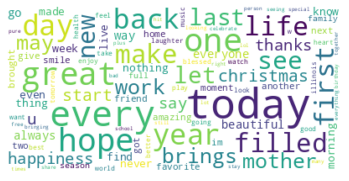

Cluster 9



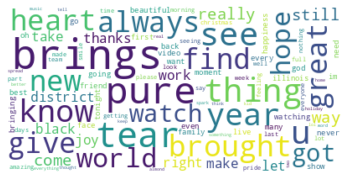

Cluster 10



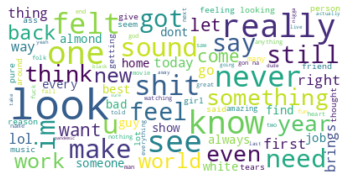

Cluster 11



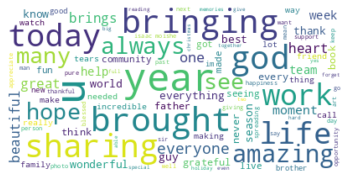

Cluster 12



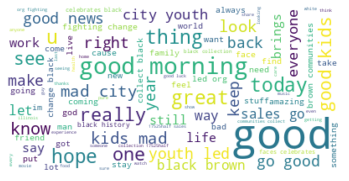

Cluster 13



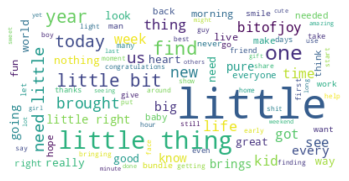

Cluster 14



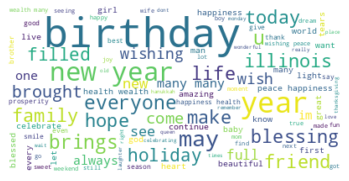

Cluster 15



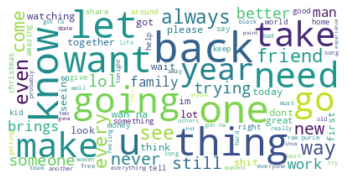

Cluster 16



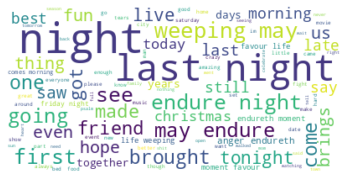

Cluster 17



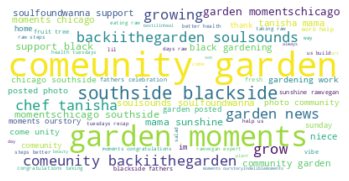

In [20]:
# clustering on tfidf vectors with sparse rows with only 3 words removed
c_model = clust(c, k=18)
word_clouds(tfidf_vectors, c_model, k=18)

In [6]:
# COUNT VECTORS CLUSTERING COMPARISON
x = remove_sparse_rows(count_vectors, 1)

count_vectors.shape, x.shape

((18226, 19971), (14377, 19971))

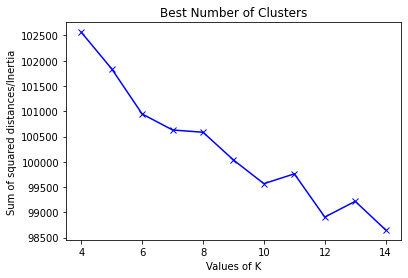

In [7]:
# selecting best value for k
best_k(x)

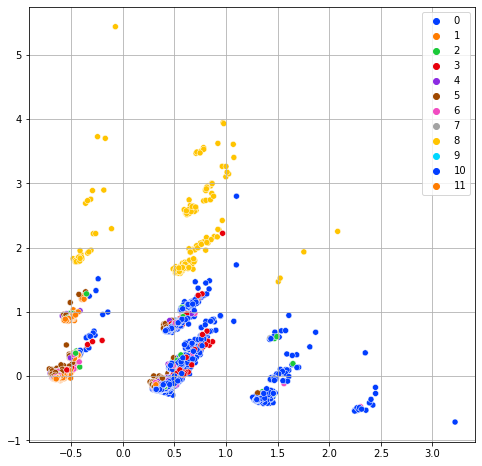

Cluster 0



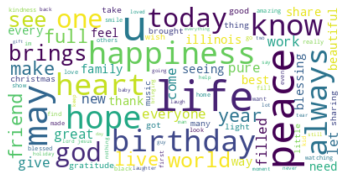

Cluster 1



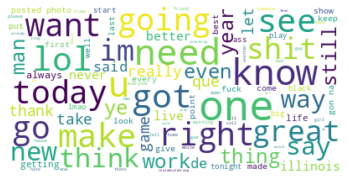

Cluster 2



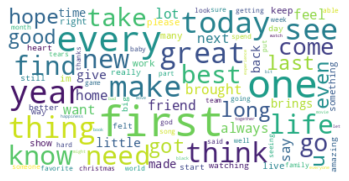

Cluster 3



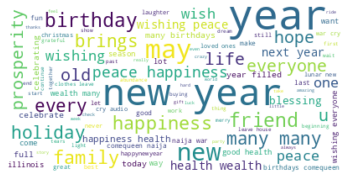

Cluster 4



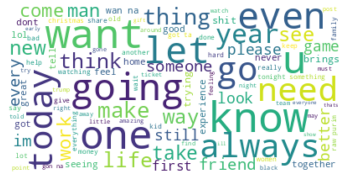

Cluster 5



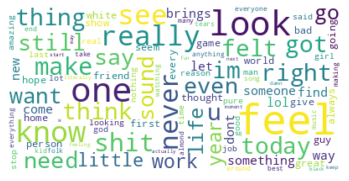

Cluster 6



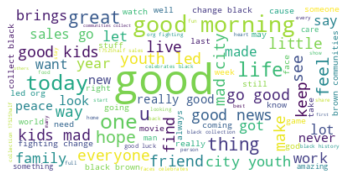

Cluster 7



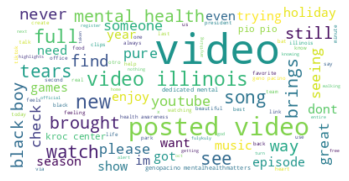

Cluster 8



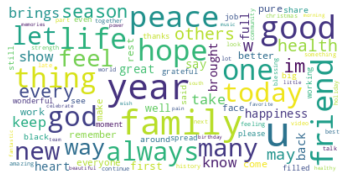

Cluster 9



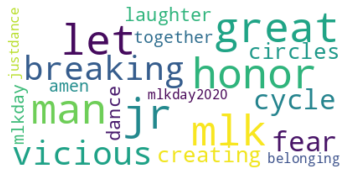

Cluster 10



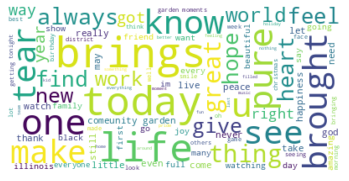

Cluster 11



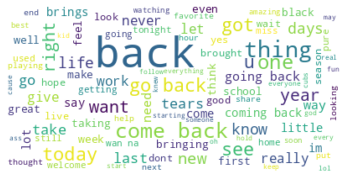

In [8]:
# clustering on count vectors with sparse rows with only 1 word removed
x_model = clust(x, k=12)
word_clouds(count_vectors, x_model, k=12)

In [9]:
y = remove_sparse_rows(count_vectors, 2)

count_vectors.shape, y.shape

((18226, 19971), (12304, 19971))

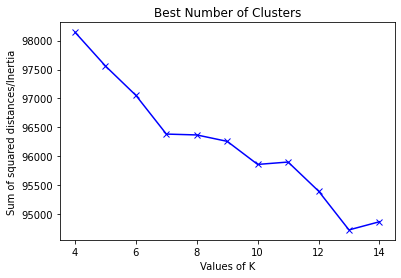

In [10]:
# selecting best value for k
best_k(y)

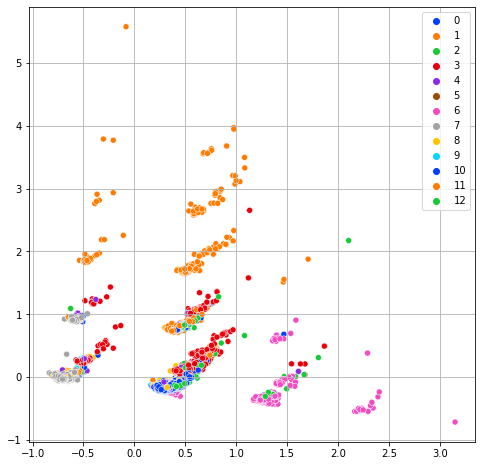

Cluster 0



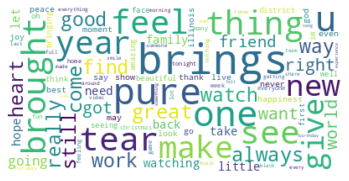

Cluster 1



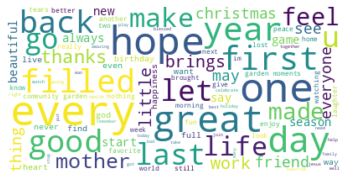

Cluster 2



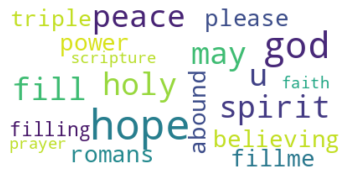

Cluster 3



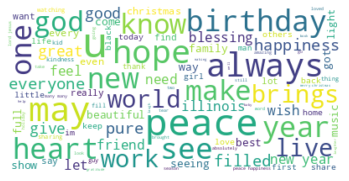

Cluster 4



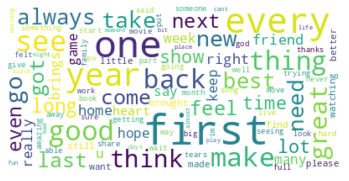

Cluster 5



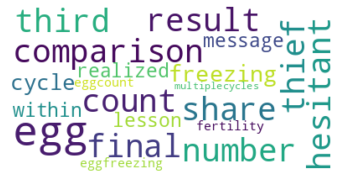

Cluster 6



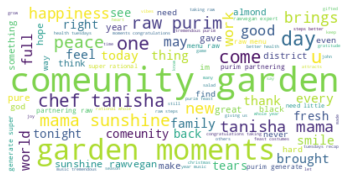

Cluster 7



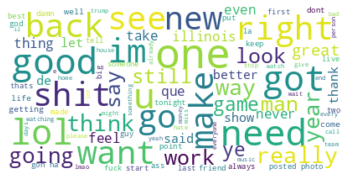

Cluster 8



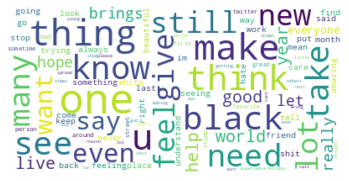

Cluster 9



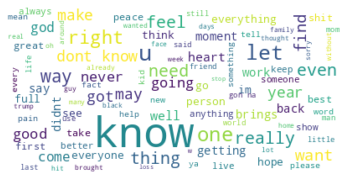

Cluster 10



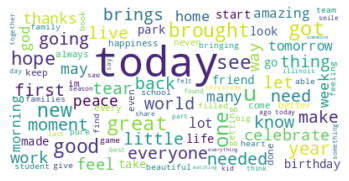

Cluster 11



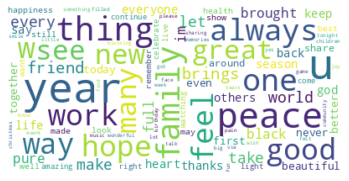

Cluster 12



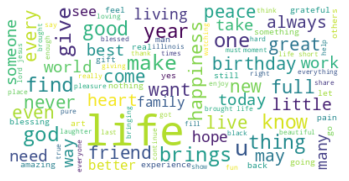

In [11]:
# clustering on count vectors with sparse rows with only 2 words removed
y_model = clust(y, k=13)
word_clouds(count_vectors, y_model, k=13)

In [12]:
z = remove_sparse_rows(count_vectors, 3)

count_vectors.shape, z.shape

((18226, 19971), (10491, 19971))

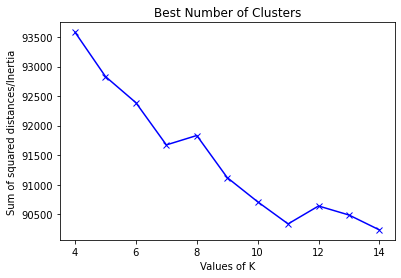

In [13]:
# selecting best value for k
best_k(z)

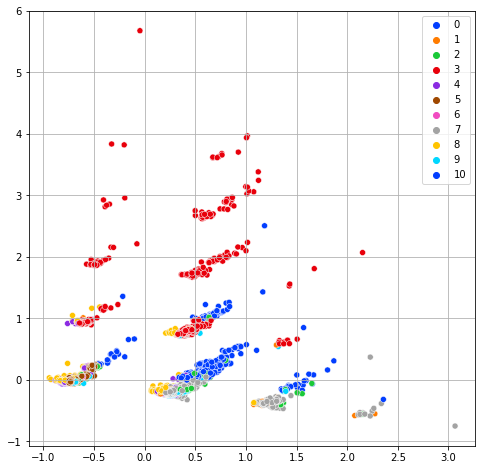

Cluster 0



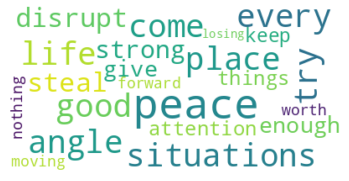

Cluster 1



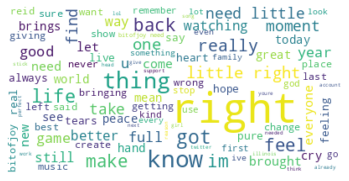

Cluster 2



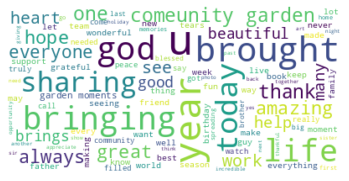

Cluster 3



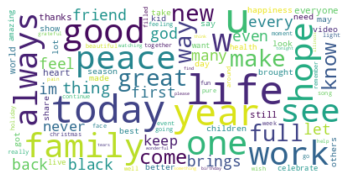

Cluster 4



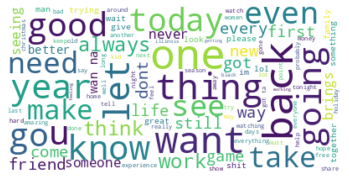

Cluster 5



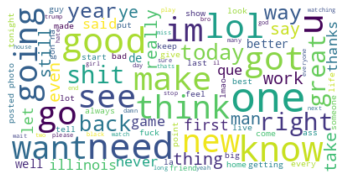

Cluster 6



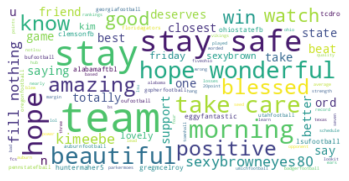

Cluster 7



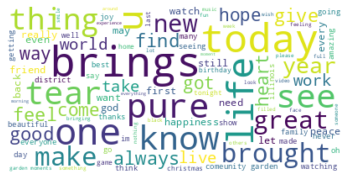

Cluster 8



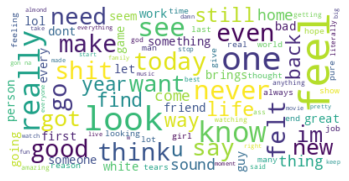

Cluster 9



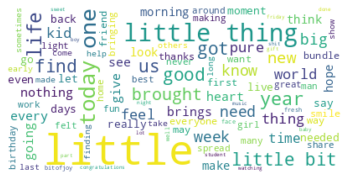

Cluster 10



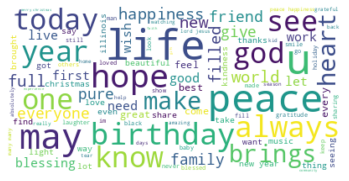

In [14]:
# clustering on count vectors with sparse rows with only 2 words removed
z_model = clust(z, k=11)
word_clouds(count_vectors, z_model, k=11)